# Лабораторная работа №1


Цель работы — понять и исследовать уязвимости современных нейронных сетей к adversarial атакам (в частности, FGSM (Fast Gradient Sign Method) и DeepFool атак.)

In [ ]:
FGSM (Fast Gradient Sign Method)  -  добавить к изображению шум, который максимизирует ошибку модели.
DeepFool - ищет минимальное по норме изменение, необходимое для изменения класса, генерирует менее заметные и более естественные атаки по сравнению с FGSM.

Ход работы:
1. Клонируем и запускаем проект с GitHub.
2. Загружаем и подготавливаем датасеты MNIST и CIFAR-10 с нормализацией и аугментацией.
3. Загружаем предобученные модели (LeNet, Network-in-Network, FCNet) для этих датасетов.
4. Проводим оценку устойчивости моделей к FGSM и DeepFool атакам с разными параметрами.
5. Визуализируем атакующие примеры и анализируем влияние параметра ε (eps) на качество и устойчивость моделей.


In [ ]:
!git clone https://github.com/ewatson2/EEL6812_DeepFool_Project
%cd /content/EEL6812_DeepFool_Project # для смены текущей рабочей директории в средах на базе Jupyter

Cloning into 'EEL6812_DeepFool_Project'...
remote: Enumerating objects: 96, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 96 (delta 2), reused 1 (delta 1), pack-reused 93 (from 1)
Receiving objects: 100% (96/96), 33.99 MiB | 22.88 MiB/s, done.
Resolving deltas: 100% (27/27), done.
[Errno 2] No such file or directory: '/content/EEL6812_DeepFool_Project # для смены текущей рабочей директории в средах на базе Jupyter'
/content/EEL6812_DeepFool_Project


In [ ]:
import numpy as np # удобные структуры данных (массивы, матрицы) и функции для работы с ними
import json, torch # чтения и записи данных в формате JSON
"""
PyTorch — это одна из самых популярных библиотек для глубокого обучения.
Импорт torch даёт доступ к основным функциям и структурам PyTorch: тензорам, вычислениям на GPU, построению нейросетей и т.д
"""
from torch.utils.data import DataLoader, random_split
"""
DataLoader — класс, который помогает удобно загружать данные пакетами (батчами), перемешивать их, загружать параллельно с помощью нескольких потоков.
Это облегчает обучение моделей, позволяя эффективно обрабатывать большие датасеты.
random_split — функция для случайного разбиения датасета на части, например, на обучающую и тестовую выборки, что важно для оценки качества модели.
"""
from torchvision import datasets, models, transforms
"""
torchvision — библиотека, расширяющая PyTorch, с готовыми датасетами, предобученными моделями и инструментами для обработки изображений.
datasets — содержит популярные датасеты (например, CIFAR-10, MNIST), которые можно легко загрузить.
models — предоставляет предобученные модели (ResNet, VGG и др.) для быстрого старта.
transforms — набор функций для преобразования изображений (например, изменение размера, нормализация, аугментация), что помогает подготовить данные для обучения.
"""

'\ntorchvision — библиотека, расширяющая PyTorch, с готовыми датасетами, предобученными моделями и инструментами для обработки изображений.\ndatasets — содержит популярные датасеты (например, CIFAR-10, MNIST), которые можно легко загрузить.\nmodels — предоставляет предобученные модели (ResNet, VGG и др.) для быстрого старта.\ntransforms — набор функций для преобразования изображений (например, изменение размера, нормализация, аугментация), что помогает подготовить данные для обучения.\n'

# Импорт вспомогательных библиотек из локальных файлов проекта

In [ ]:
from models.project_models import FC_500_150, LeNet_CIFAR, LeNet_MNIST, Net
"""
Здесь импортируются архитектуры нейронных сетей
FC_500_150 — вероятно, это полносвязная (fully connected) нейросеть с двумя скрытыми слоями по 500 и 150 нейронов.
LeNet_CIFAR и LeNet_MNIST — варианты классической архитектуры LeNet, адаптированные под разные датасеты:
LeNet — это одна из первых и самых известных сверточных нейросетей, хорошо подходящая для распознавания изображений, например, рукописных цифр (MNIST) или цветных изображений CIFAR-10.
Net — базовая сеть.
"""
from utils.project_utils import get_clip_bounds, evaluate_attack, display_attack
"""
вспомогательные функции, которые помогают в работе с атаками и анализом результатов:
get_clip_bounds — функция, вероятно, возвращает границы значений (например, минимальные и максимальные пиксельные значения), чтобы при модификации изображений не выходить за допустимые пределы.
evaluate_attack — функция для оценки эффективности атаки на модель, например, насколько успешно атака изменила предсказания сети.
display_attack — функция для визуализации результатов атаки, например, показывающая исходное изображение, искажённое изображение и разницу между ними.
"""

'\nвспомогательные функции, которые помогают в работе с атаками и анализом результатов:\nget_clip_bounds — функция, вероятно, возвращает границы значений (например, минимальные и максимальные пиксельные значения), чтобы при модификации изображений не выходить за допустимые пределы.\nevaluate_attack — функция для оценки эффективности атаки на модель, например, насколько успешно атака изменила предсказания сети.\ndisplay_attack — функция для визуализации результатов атаки, например, показывающая исходное изображение, искажённое изображение и разницу между ними.\n'

In [ ]:
rand_seed = 2
np.random.seed(rand_seed)
torch.manual_seed(rand_seed)

# Загрузка датасета MNIST

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print ("device", device)

device cuda


In [ ]:
mnist_mean = 0.5 # среднее значение для нормализации.
mnist_std = 0.5 # стандартное отклонение для нормализации.
mnist_dim = 28 # Это размерность изображений MNIST — 28 пикселей по ширине и высоте.

In [ ]:
mnist_min, mnist_max = get_clip_bounds(mnist_mean, mnist_std, mnist_dim)
"""
вычисляет нижние и верхние границы допустимых значений пикселей после нормализации.
"""
"""
Изображения MNIST обычно нормализуют с помощью среднего (mnist_mean) и стандартного отклонения (mnist_std)
Но при изменении изображения (например, при создании атакующих примеров) важно, чтобы значения пикселей не выходили за реальные допустимые пределы.
get_clip_bounds возвращает два тензора или массива:
mnist_min — минимально допустимое значение пикселя после нормализации,
mnist_max — максимально допустимое значение пикселя после нормализации, учитывая размерность изображения mnist_dim.
"""
mnist_min = mnist_min.to(device)
mnist_max = mnist_max.to(device)
"""
перемещают эти границы на выбранное устройство (CPU или GPU), чтобы можно было эффективно использовать их при вычислениях с тензорами на том же устройстве
"""

'\nперемещают эти границы на выбранное устройство (CPU или GPU), чтобы можно было эффективно использовать их при вычислениях с тензорами на том же устройстве\n'

  Выполняем подготовку данных для обучения

In [ ]:
"""
transforms.Compose
Это способ последовательно применить несколько преобразований к изображению.
"""

#mnist_tf (базовая трансформация)
#Это помогает модели быстрее и стабильнее обучаться, так как входные данные стандартизированы и имеют одинаковый масштаб.
mnist_tf = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mnist_mean, std=mnist_std)])
"""
    transforms.ToTensor()
Преобразует изображение из формата PIL Image или NumPy массива в тензор PyTorch с типом FloatTensor.
При этом пиксели масштабируются из диапазона [0, 255] в [0.0, 1.0].
    """
"""
transforms.Normalize(mean=mnist_mean, std=mnist_std)
Нормализует тензор по формуле:
(x - mean) / std
В вашем случае mnist_mean = 0.5, mnist_std = 0.5, значит:
Значения пикселей, которые были в [0,1], теперь будут в диапазоне примерно [-1, 1].
Например, пиксель 0 → (0 - 0.5)/0.5 = -1
Пиксель 1 → (1 - 0.5)/0.5 = 1
Это помогает модели быстрее и стабильнее обучаться, так как данные стандартизированы.
"""
#mnist_tf_train (трансформация для обучения)
#Это улучшает обобщающую способность модели за счет расширения обучающего набора.
mnist_tf_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=mnist_mean, std=mnist_std)])
"""
    transforms.RandomHorizontalFlip() — случайно переворачивает изображение по горизонтали с вероятностью 0.5.
    """
#mnist_tf_inv (обратная трансформация)
#Позволяет восстановить исходное изображение из нормализованного тензора.
mnist_tf_inv = transforms.Compose([
    transforms.Normalize(mean=0.0, std=np.divide(1.0, mnist_std)),
    transforms.Normalize(mean=np.multiply(-1.0, mnist_std), std=1.0)])
"""
Это обратная трансформация, которая восстанавливает изображение из нормализованного состояния обратно к исходному виду.
Состоит из двух последовательных нормализаций:
transforms.Normalize(mean=0.0, std=1/mnist_std)
Делит значения на 1/mnist_std, то есть умножает на mnist_std (в вашем случае 0.5), тем самым возвращая масштаб к исходному.
transforms.Normalize(mean=-mnist_mean, std=1.0)
Вычитает mnist_mean (0.5), возвращая среднее значение к исходному.
В итоге, если применить mnist_tf_inv к нормализованному тензору, вы получите изображение в диапазоне [0,1], пригодное для визуализации или дальнейшей обработки.
"""
"""
Нормализация помогает модели обучаться эффективнее, так как входные данные имеют одинаковый масштаб и распределение.
Аугментация (например, случайное отражение) увеличивает разнообразие данных и снижает переобучение.
Обратная трансформация нужна, чтобы визуализировать результаты (например, показать атакованное изображение в привычном виде).
"""

'\nНормализация помогает модели обучаться эффективнее, так как входные данные имеют одинаковый масштаб и распределение.\nАугментация (например, случайное отражение) увеличивает разнообразие данных и снижает переобучение.\nОбратная трансформация нужна, чтобы визуализировать результаты (например, показать атакованное изображение в привычном виде).\n'

Загружаем два набора данных mnist с разделением на обучающую и тестовую выборки с аугментанцикй (с горизонитальным отражением) и без аугментации

In [ ]:
mnist_temp = datasets.MNIST(root='datasets/mnist', train=True, download=True, transform=mnist_tf_train)
"""
datasets.MNIST(...) — это класс из библиотеки torchvision, который автоматически скачивает (если нужно) и загружает датасет MNIST — набор из 70,000 изображений рукописных цифр (60,000 для обучения и 10,000 для теста).
Параметры:
root='datasets/mnist' — папка, куда сохраняется датасет.
train=True — загружается обучающая часть (60,000 изображений).
download=True — если датасет отсутствует локально, он будет скачан.
transform=mnist_tf_train — к изображениям применяется набор преобразований, включая аугментацию (например, случайное горизонтальное отражение) и нормализацию.
"""
mnist_train, mnist_val = random_split(mnist_temp, [50000, 10000])
"""
random_split(mnist_temp, [50000, 10000]) — случайно делит загруженный датасет из 60,000 изображений на:
mnist_train — 50,000 изображений для обучения модели,
mnist_val — 10,000 изображений для валидации (проверки качества модели во время обучения).
Это стандартная практика, чтобы контролировать переобучение и подбирать гиперпараметры.
"""
mnist_test = datasets.MNIST(root='datasets/mnist', train=False, download=True, transform=mnist_tf)
"""
datasets.MNIST(..., train=False, ...) — загружает тестовую часть датасета (10,000 изображений), которая используется для окончательной оценки качества модели.
Для теста применяется трансформация mnist_tf без аугментации, только нормализация.
"""

100%|██████████| 9.91M/9.91M [00:00<00:00, 16.5MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 499kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.53MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.25MB/s]


'\ndatasets.MNIST(..., train=False, ...) — загружает тестовую часть датасета (10,000 изображений), которая используется для окончательной оценки качества модели.\nДля теста применяется трансформация mnist_tf без аугментации, только нормализация.\n'

# Загрузка датасета CIFAR-10

In [ ]:
cifar_mean = [0.491, 0.482, 0.447]
cifar_std = [0.202, 0.199, 0.201]
cifar_dim = 32

"""
cifar_mean и cifar_std — это средние значения и стандартные отклонения по каналам RGB для датасета CIFAR-10.
Значения взяты из статистики всего датасета и используются для нормализации изображений.
Нормализация помогает привести данные к единому масштабу, что улучшает обучение моделей.
cifar_dim = 32 — размер изображений CIFAR-10: 32x32 пикселя.
"""
#get_clip_bounds — функция, которая вычисляет минимальные и максимальные допустимые значения пикселей после нормализации,
#чтобы ограничить значения в определённом диапазоне.
#Это важно для предотвращения выхода значений за пределы, которые могут негативно повлиять на обучение или визуализацию.
cifar_min, cifar_max = get_clip_bounds(cifar_mean, cifar_std, cifar_dim)
cifar_min = cifar_min.to(device)
cifar_max = cifar_max.to(device)

cifar_tf = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=cifar_mean, std=cifar_std)])

cifar_tf_train = transforms.Compose([
    transforms.RandomCrop(size=cifar_dim, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=cifar_mean, std=cifar_std)])
"""
RandomCrop(size=cifar_dim, padding=4) — случайно обрезает изображение до 32x32 с добавлением паддинга 4 пикселя, что увеличивает разнообразие данных.
"""

cifar_tf_inv = transforms.Compose([
    transforms.Normalize(mean=[0.0, 0.0, 0.0], std=np.divide(1.0, cifar_std)),
    transforms.Normalize(mean=np.multiply(-1.0, cifar_mean), std=[1.0, 1.0, 1.0])])
"""
cifar_tf_inv — обратная трансформация, которая восстанавливает изображение из нормализованного состояния обратно к исходному виду (например, для визуализации).
Сначала масштабирует обратно, умножая на стандартное отклонение.
Затем сдвигает значения, добавляя среднее.
"""

cifar_temp = datasets.CIFAR10(root='datasets/cifar-10', train=True, download=True, transform=cifar_tf_train)
cifar_train, cifar_val = random_split(cifar_temp, [40000, 10000])

cifar_test = datasets.CIFAR10(root='datasets/cifar-10', train=False, download=True, transform=cifar_tf)
#помогает связывать предсказания модели с реальными категориями.
cifar_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

100%|██████████| 170M/170M [00:03<00:00, 42.6MB/s]


# Настройка и загрузка DataLoader

In [ ]:
batch_size = 64
workers = 4

mnist_loader_train = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=workers)
mnist_loader_val = DataLoader(mnist_val, batch_size=batch_size, shuffle=False, num_workers=workers)
mnist_loader_test = DataLoader(mnist_test, batch_size=batch_size, shuffle=False, num_workers=workers)

cifar_loader_train = DataLoader(cifar_train, batch_size=batch_size, shuffle=True, num_workers=workers)
cifar_loader_val = DataLoader(cifar_val, batch_size=batch_size, shuffle=False, num_workers=workers)
cifar_loader_test = DataLoader(cifar_test, batch_size=batch_size, shuffle=False, num_workers=workers)
"""
DataLoader — это класс из PyTorch, который отвечает за удобную и эффективную загрузку данных во время обучения и тестирования моделей.
Он берёт датасет и разбивает его на мини-батчи (пакеты) заданного размера (batch_size).
Также может перемешивать данные (shuffle=True), загружать данные параллельно с помощью нескольких потоков (num_workers), что ускоряет процесс.
batch_size=64
Размер одного батча — количество примеров, которые модель будет обрабатывать за один шаг обучения или оценки.
Использование батчей позволяет эффективнее использовать память и ускоряет обучение.
workers=4
Количество параллельных потоков для загрузки данных.
Позволяет загружать и обрабатывать данные быстрее, не задерживая обучение.
shuffle=True для обучающих загрузчиков
Перемешивает данные перед каждой эпохой, чтобы модель не училась на одном и том же порядке примеров, что улучшает обобщение.
shuffle=False для валидации и теста
Данные не перемешиваются, чтобы результаты оценки были стабильными и воспроизводимыми.
"""

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


'\nDataLoader — это класс из PyTorch, который отвечает за удобную и эффективную загрузку данных во время обучения и тестирования моделей.\nОн берёт датасет и разбивает его на мини-батчи (пакеты) заданного размера (batch_size).\nТакже может перемешивать данные (shuffle=True), загружать данные параллельно с помощью нескольких потоков (num_workers), что ускоряет процесс.\nbatch_size=64\nРазмер одного батча — количество примеров, которые модель будет обрабатывать за один шаг обучения или оценки.\nИспользование батчей позволяет эффективнее использовать память и ускоряет обучение.\nworkers=4\nКоличество параллельных потоков для загрузки данных.\nПозволяет загружать и обрабатывать данные быстрее, не задерживая обучение.\nshuffle=True для обучающих загрузчиков\nПеремешивает данные перед каждой эпохой, чтобы модель не училась на одном и том же порядке примеров, что улучшает обобщение.\nshuffle=False для валидации и теста\nДанные не перемешиваются, чтобы результаты оценки были стабильными и восп

# Загрузка и оценка стойкости модели Network-In-Network Model к FGSM и DeepFool атакам на основе датасета CIFAR-10

In [ ]:
fgsm_eps = 0.2
deep_batch_size = 10
deep_num_classes = 10
deep_overshoot = 0.02
deep_max_iters = 50
deep_args = [deep_batch_size, deep_num_classes,
             deep_overshoot, deep_max_iters]

"""
fgsm_eps = 0.2 — параметр ε для атаки FGSM (Fast Gradient Sign Method), который задаёт максимальный размер изменения пикселей при создании adversarial-примеров. Чем больше ε, тем сильнее и заметнее атака.
Параметры для DeepFool-атаки:
deep_batch_size = 10 — размер батча для обработки.
deep_num_classes = 10 — количество классов (CIFAR-10 содержит 10 классов).
deep_overshoot = 0.02 — параметр, контролирующий, насколько сильно DeepFool "перешагивает" границу решения для успешной атаки.
deep_max_iters = 50 — максимальное число итераций для поиска adversarial-примера.
Все параметры DeepFool объединены в список deep_args.
"""

model = Net().to(device)
model.load_state_dict(torch.load('weights/clean/cifar_nin.pth'))
"""
model = Net().to(device) — создаётся экземпляр модели Net и переносится на устройство (CPU или GPU).
model.load_state_dict(torch.load('weights/clean/cifar_nin.pth')) — загружаются заранее обученные веса модели из файла. В данном случае, это модель, обученная на CIFAR-10.
"""

evaluate_attack('cifar_nin_fgsm.csv', 'results',
                device, model, cifar_loader_test,
                cifar_min, cifar_max, fgsm_eps, is_fgsm=True)
print('')
evaluate_attack('cifar_nin_deepfool.csv', 'results',
                device, model, cifar_loader_test,
                cifar_min, cifar_max, deep_args, is_fgsm=False)
"""
evaluate_attack(...) — функция, которая запускает атаку на модель и оценивает её эффективность.
Первый вызов с is_fgsm=True запускает FGSM-атаку с параметром fgsm_eps на тестовом наборе CIFAR-10. Результаты сохраняются в файл 'cifar_nin_fgsm.csv' в папке 'results'.
Второй вызов с is_fgsm=False запускает DeepFool-атаку с параметрами из deep_args и сохраняет результаты в 'cifar_nin_deepfool.csv'.
В обоих случаях используются границы cifar_min и cifar_max для ограничения значений пикселей после атаки, чтобы изображения оставались валидными.
"""
if device.type == 'cuda':
    torch.cuda.empty_cache()
"""
 if device.type == 'cuda': torch.cuda.empty_cache() — если используется GPU, освобождается неиспользуемая память CUDA, чтобы избежать переполнения и повысить производительность.
"""
"""
1. Test Error (Ошибка на тесте)
FGSM Test Error : 81.29%
Процент ошибок модели на тестовом наборе после применения FGSM-атаки.
Значит, модель ошибается примерно в 81.29% случаев, когда её пытаются обмануть с помощью FGSM.
DeepFool Test Error : 93.76%
Аналогично, но для DeepFool-атаки — модель ошибается в 93.76% случаев.
Чем выше этот показатель, тем более успешна атака и тем менее устойчива модель.
2. Robustness (Устойчивость модели)
FGSM Robustness : 1.77e-01 (0.177)
DeepFool Robustness : 2.12e-02 (0.0212)
Этот параметр отражает среднюю минимальную величину возмущения (изменения) изображения, необходимую для того, чтобы модель ошиблась.
Чем меньше значение, тем менее устойчива модель — ей достаточно очень маленьких изменений, чтобы ошибиться.
В данном случае DeepFool требует гораздо меньших изменений, чем FGSM, чтобы обмануть модель.
3. Time (Время выполнения атаки)
FGSM Time (All Images) : 0.67 s — время, затраченное на атаку FGSM по всему тестовому набору.
FGSM Time (Per Image) : 67.07 µs (микросекунд) — среднее время атаки на одно изображение.
DeepFool Time (All Images) : 185.12 s — время, затраченное на DeepFool-атаку по всему тесту.
DeepFool Time (Per Image) : 18.51 ms (миллисекунд) — среднее время на одно изображение.
DeepFool значительно медленнее FGSM, так как это более сложный и итеративный метод.

"""

FGSM Test Error : 81.29%
FGSM Robustness : 1.77e-01
FGSM Time (All Images) : 0.67 s
FGSM Time (Per Image) : 67.07 us

DeepFool Test Error : 93.76%
DeepFool Robustness : 2.12e-02
DeepFool Time (All Images) : 185.12 s
DeepFool Time (Per Image) : 18.51 ms


'\n1. Test Error (Ошибка на тесте)\nFGSM Test Error : 81.29%\nПроцент ошибок модели на тестовом наборе после применения FGSM-атаки.\nЗначит, модель ошибается примерно в 81.29% случаев, когда её пытаются обмануть с помощью FGSM.\nDeepFool Test Error : 93.76%\nАналогично, но для DeepFool-атаки — модель ошибается в 93.76% случаев.\nЧем выше этот показатель, тем более успешна атака и тем менее устойчива модель.\n2. Robustness (Устойчивость модели)\nFGSM Robustness : 1.77e-01 (0.177)\nDeepFool Robustness : 2.12e-02 (0.0212)\nЭтот параметр отражает среднюю минимальную величину возмущения (изменения) изображения, необходимую для того, чтобы модель ошиблась.\nЧем меньше значение, тем менее устойчива модель — ей достаточно очень маленьких изменений, чтобы ошибиться.\nВ данном случае DeepFool требует гораздо меньших изменений, чем FGSM, чтобы обмануть модель.\n3. Time (Время выполнения атаки)\nFGSM Time (All Images) : 0.67 s — время, затраченное на атаку FGSM по всему тестовому набору.\nFGSM Tim

# LeNet пример атаки с различными параметрами `eps`

In [ ]:
Confidence score — это числовое значение, которое модель машинного обучения присваивает своему предсказанию, отражающее степень уверенности модели в правильности этого предсказания.

results for fgsm_eps = 0.001:


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


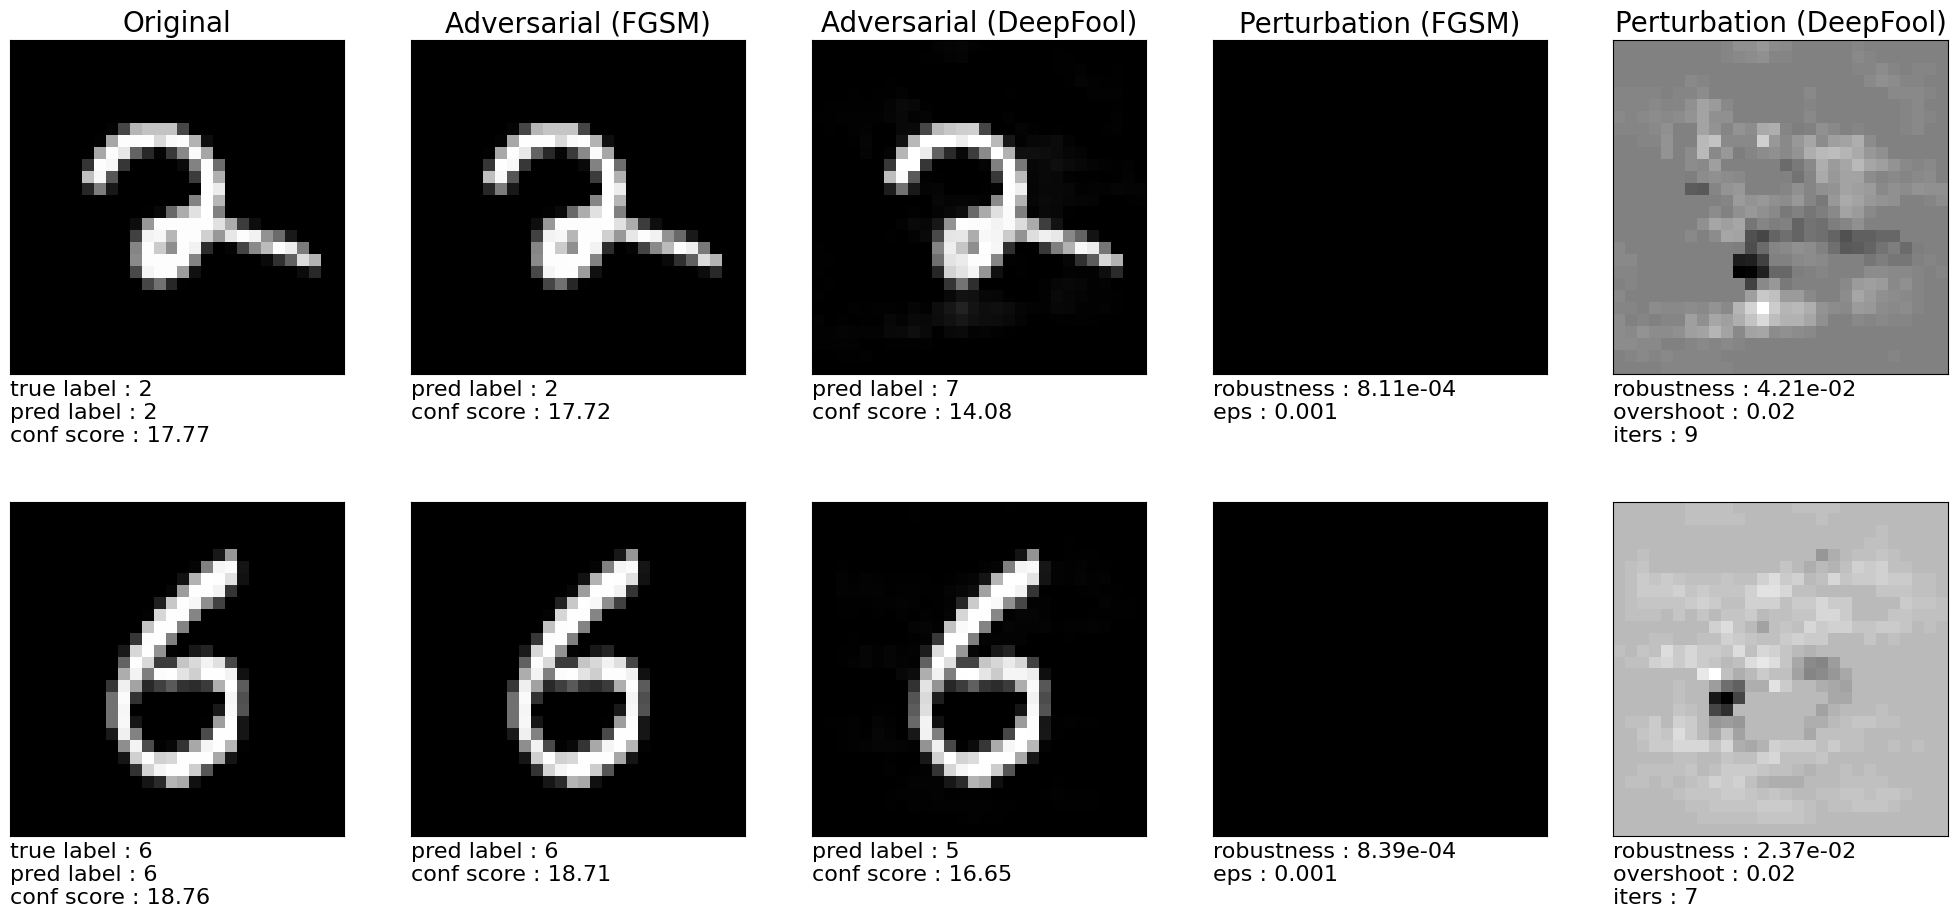

results for fgsm_eps = 0.02:


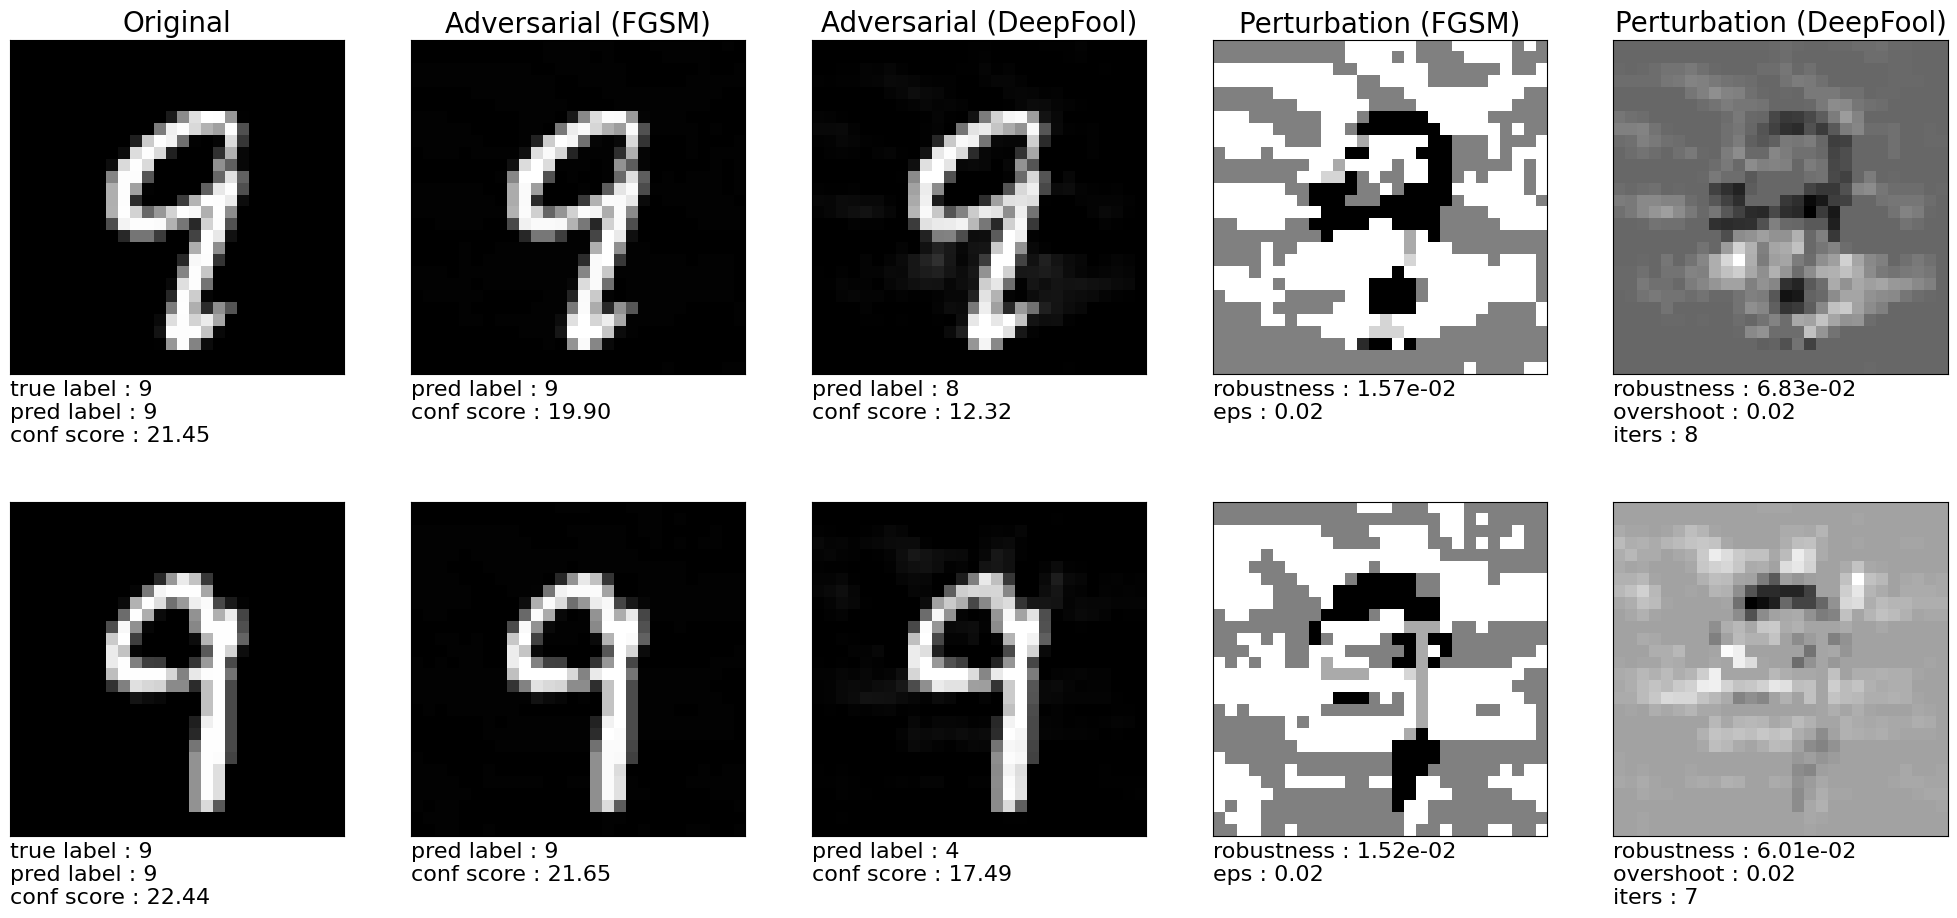

results for fgsm_eps = 0.5:


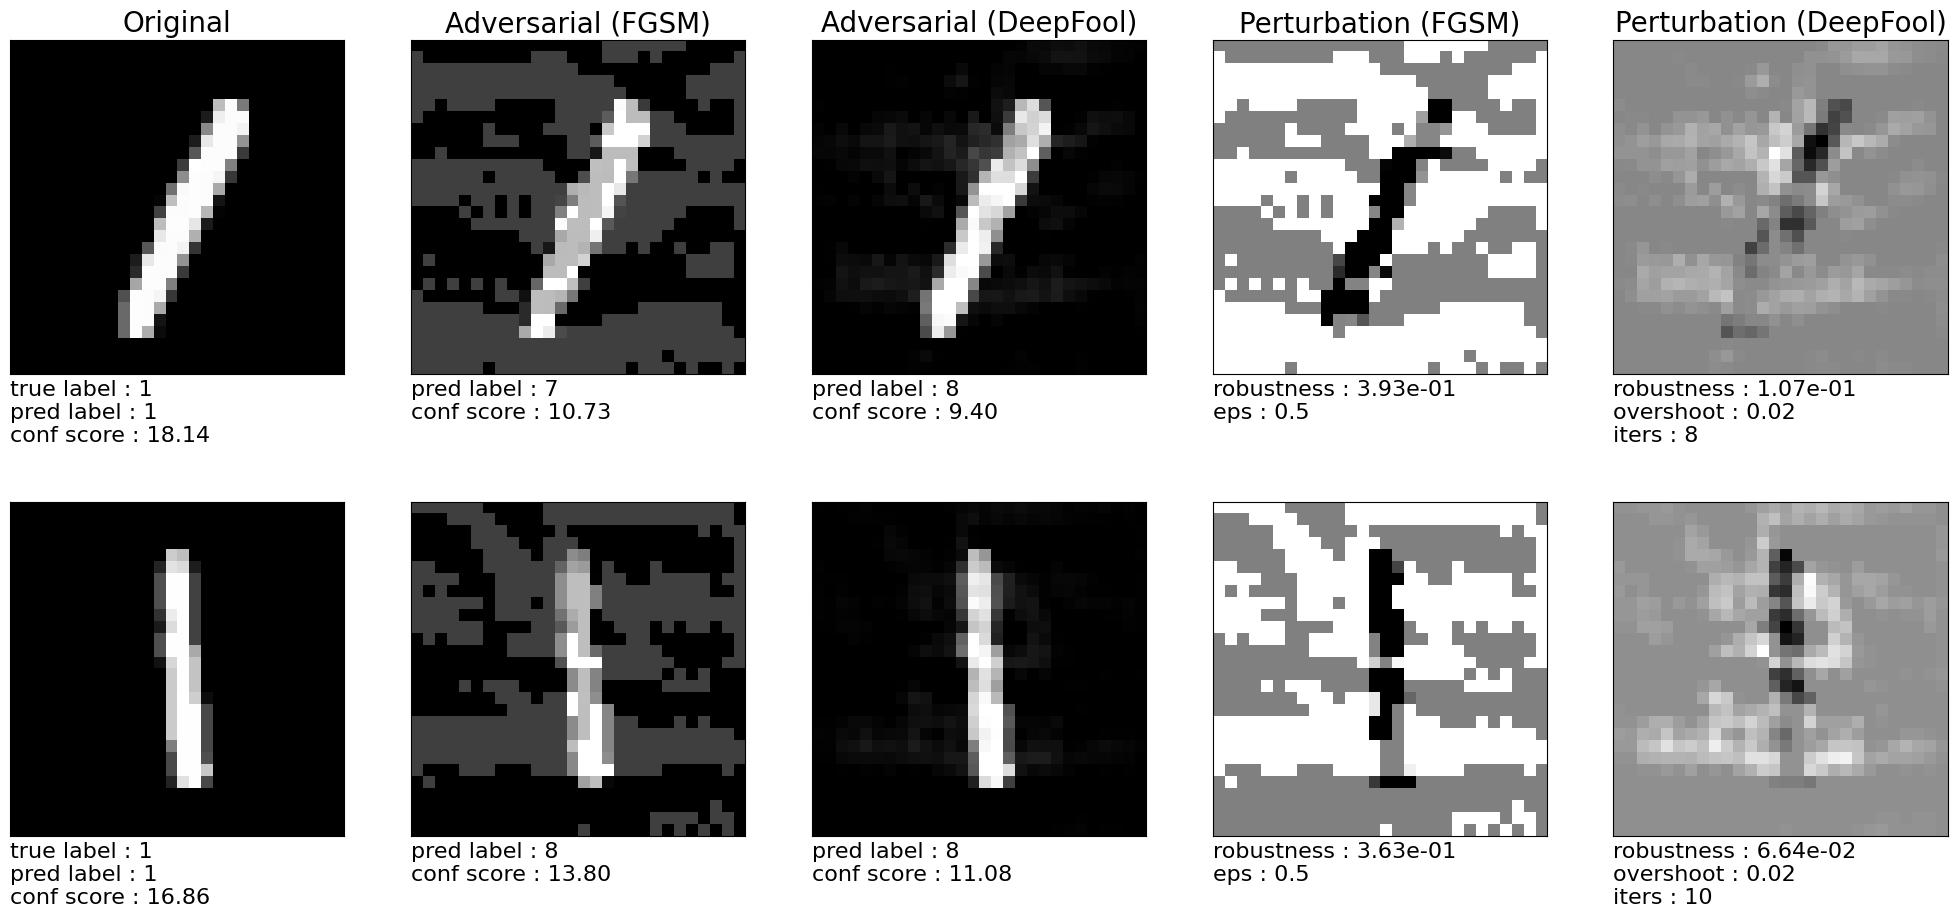

results for fgsm_eps = 0.9:


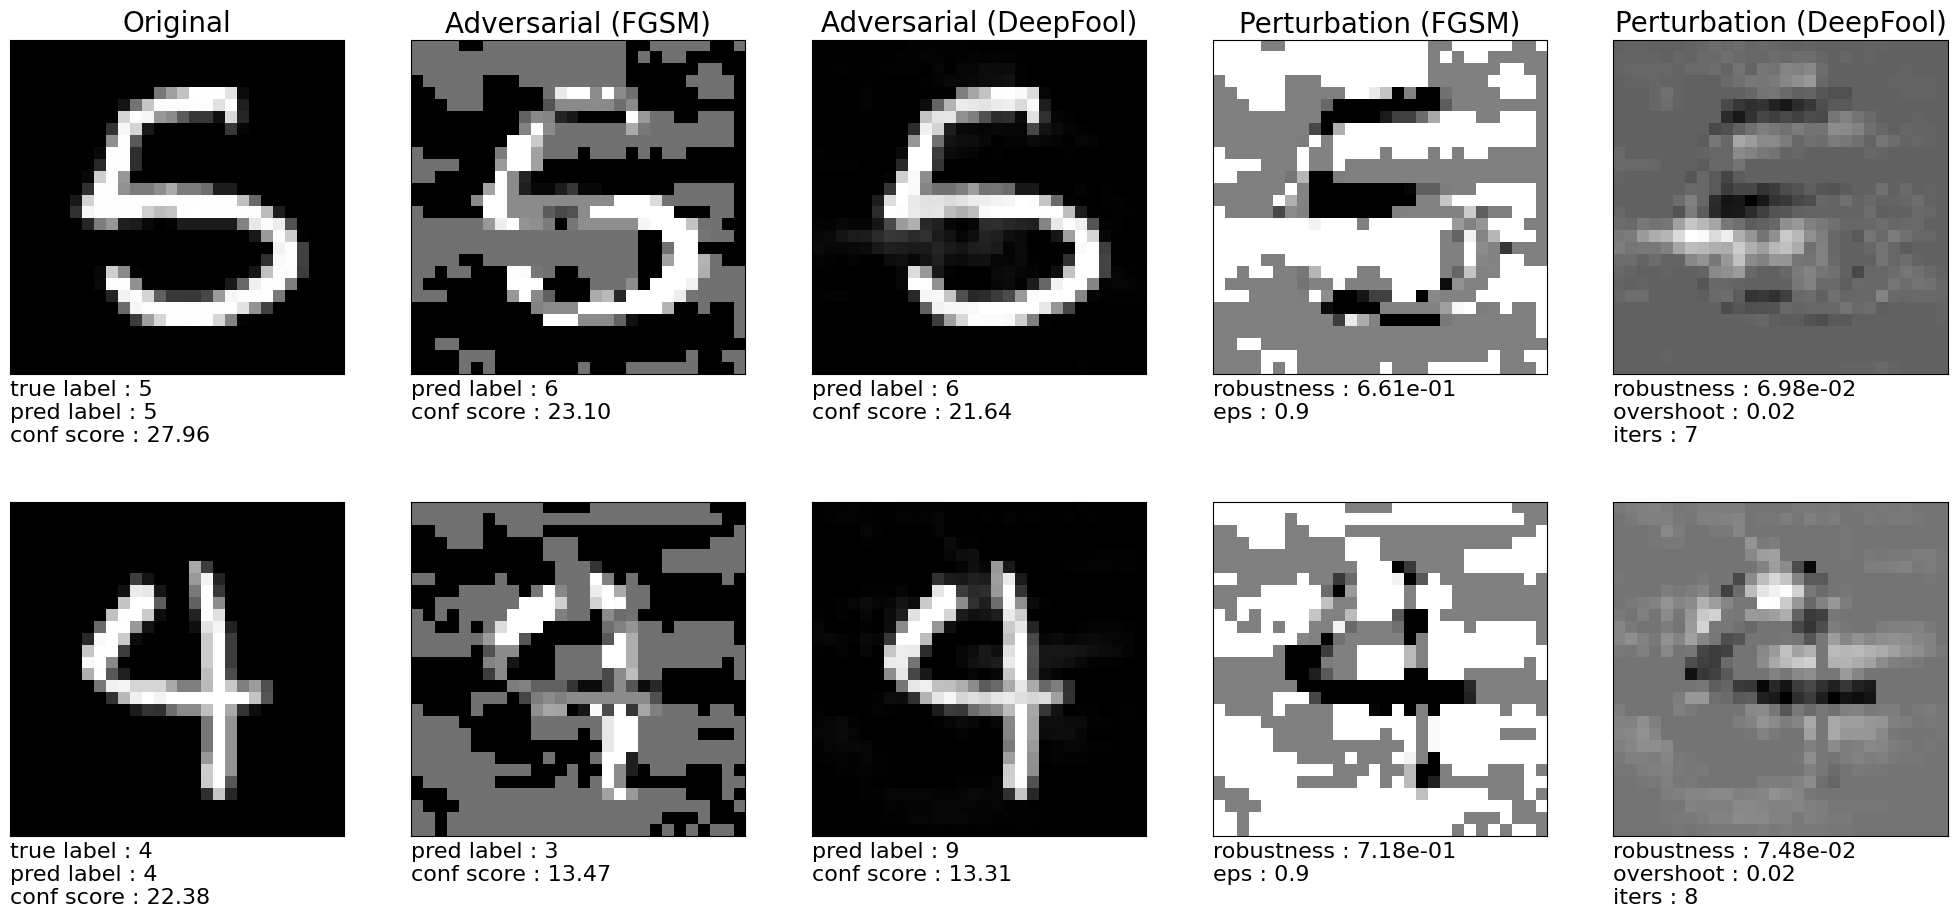

results for fgsm_eps = 10:


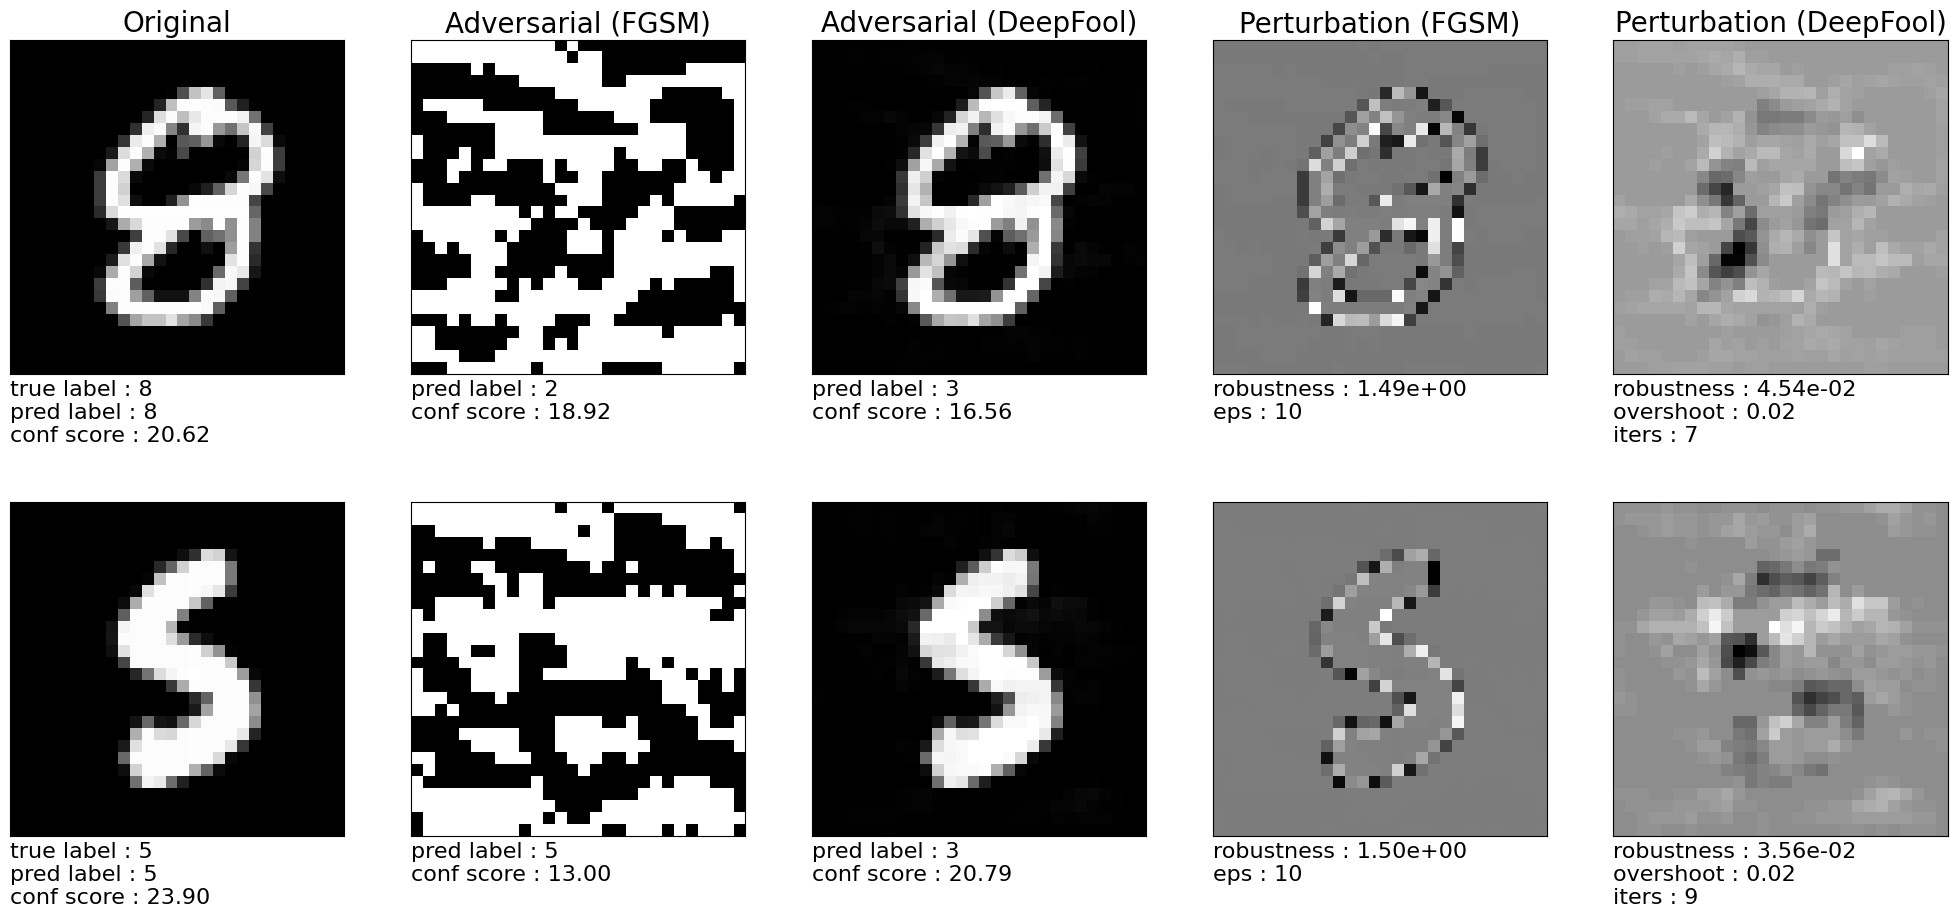

'\nДля каждого значения fgsm_eps вызывается функция display_attack, которая:\nПрименяет FGSM-атаку (и, возможно, DeepFool, учитывая deep_args) к модели на тестовом наборе MNIST.\nИспользует обратную трансформацию mnist_tf_inv, чтобы визуализировать исходные и атакованные изображения в привычном виде.\nОграничивает значения пикселей в пределах mnist_min и mnist_max, чтобы изображения оставались валидными.\nПараметры has_labels=False, l2_norm=True, pert_scale=1.0 и настройки отображения (fig_rows, fig_width, fig_height) управляют деталями визуализации и нормализации.\n'

In [ ]:
model = LeNet_MNIST().to(device)
model.load_state_dict(torch.load('weights/clean/mnist_lenet.pth'))
#Загружаются заранее обученные веса модели из файла, чтобы использовать уже обученную сеть без повторного обучения

"""
model = LeNet_MNIST().to(device) — создаёт экземпляр модели LeNet, адаптированной для задачи классификации рукописных цифр MNIST, и переносит её на выбранное устройство (CPU или GPU).
model.load_state_dict(torch.load('weights/clean/mnist_lenet.pth')) — загружает заранее обученные веса модели из файла, чтобы использовать уже обученную сеть.
"""
for fgsm_eps in [0.001, 0.02, 0.5, 0.9, 10]:
    print(f"results for fgsm_eps = {fgsm_eps}:")
    display_attack(device, model, mnist_test, mnist_tf_inv, mnist_min, mnist_max, fgsm_eps, deep_args, has_labels=False, l2_norm=True, pert_scale=1.0, fig_rows=2, fig_width=25, fig_height=11)
    if device.type == 'cuda': torch.cuda.empty_cache()
"""
fgsm_eps — параметр, задающий силу FGSM-атаки (Fast Gradient Sign Method), то есть максимальное изменение пикселей при создании adversarial-примеров.
В цикле перебираются разные значения fgsm_eps от очень маленького (0.001) до очень большого (10), чтобы посмотреть, как меняется устойчивость модели к атакам разной силы.
"""
"""
Для каждого значения fgsm_eps вызывается функция display_attack, которая:
Применяет FGSM-атаку (и, возможно, DeepFool, учитывая deep_args) к модели на тестовом наборе MNIST.
Использует обратную трансформацию mnist_tf_inv, чтобы визуализировать исходные и атакованные изображения в привычном виде.
Ограничивает значения пикселей в пределах mnist_min и mnist_max, чтобы изображения оставались валидными.
Параметры has_labels=False, l2_norm=True, pert_scale=1.0 и настройки отображения (fig_rows, fig_width, fig_height) управляют деталями визуализации и нормализации.
"""